
# Optimization & Root-Finding for a Consumer Problem

**Goal of this lecture**  
Learn how to solve a simple consumer problem numerically using three approaches:
1. **Grid search (brute force)** builds intuition, but is slow.  
1. **Optimization**  exploit the problem’s monotonicity to locate the optimum much faster.
3. **Root finding via solver** using `scipy.optimize`,  practical and general.

We'll see each numerical method and compare them in terms of speed, accuracy and efficiency.


<!-- ===== Table of Contents ===== --><a id='toc0_'></a>    
- 1. [Economic Setup: Two-Good Consumer](#toc1_)    
- 2. [Algorithm 1: Brute Force (Intuition Builder)](#toc2_)    
  - 2.1. [Getting Started:](#toc2_1_)    
- 3. [Algorithm 2: Optimization using Monotonicity](#toc3_)    
- 4. [Root-Finding and Calling a Solver](#toc4_)    
- 5. [Comparing Methods](#toc5_)    
- 6. [Summary](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Preperation I:** Function for collecting infomation while running optimizing:

## 1. <a id='toc1_'></a>[Economic Setup: Two-Good Consumer](#toc0_)

 <a id="toc0_"></a>




We study a Cobb–Douglas consumer with two goods, $x_1, x_2$.  
Utility:
$$ u(x_1, x_2) = x_1^{\alpha} x_2^{1-\alpha}, \quad 0<\alpha<1. $$


Budget Constraint:
$$ p_1 x_1 + p_2 x_2 \le I, \quad x_1 \ge 0,\; x_2 \ge 0. $$

**Parameters:**  
- $\alpha \in (0,1)$: preference weight on good 1  
- $p_1, p_2 > 0$: prices of goods 1 and 2  
- $I>0$: **income**

**Problem:**  
Maximize Cobb–Douglas utility subject to the budget:
$$
\max_{x_1,x_2 \ge 0}\; u(x_1,x_2)=x_1^{\alpha}x_2^{1-\alpha}
\quad\text{s.t.}\quad p_1x_1+p_2x_2\le I.
$$

**FOC (interior optimum, budget binds):**  
Lagrangian: $\mathcal L=x_1^{\alpha}x_2^{1-\alpha}+\lambda\,(I-p_1x_1-p_2x_2)$

First-Order Conditions:
$$
\frac{\partial \mathcal L}{\partial x_1}=\alpha x_1^{\alpha-1}x_2^{1-\alpha}-\lambda p_1=0,\qquad
\frac{\partial \mathcal L}{\partial x_2}=(1-\alpha)x_1^{\alpha}x_2^{-\alpha}-\lambda p_2=0.
$$


Divide the two FOCs to eliminate $\lambda$ (MRS = price ratio):
$$
\frac{\alpha/x_1}{(1-\alpha)/x_2}=\frac{p_1}{p_2}.
$$


Economic intuition:
- The consumer chooses the **best affordable bundle** in the budget set.
- With Cobb–Douglas, the **marginal rate of substitution (MRS)** equals the **price ratio** at the optimum:
  $$ \text{MRS} = \frac{MU_1}{MU_2} = \frac{\alpha/x_1}{(1-\alpha)/x_2} = \frac{p_1}{p_2}. $$


We can further the the FOCs from above and eliminate $x_2$ via the budget:
$$
x_2(x_1)=\frac{I-p_1x_1}{p_2}.
$$

Define on $x_1\in(0,I/p_1)$:
$$
F(x_1)=\frac{\alpha/x_1}{(1-\alpha)/x_2(x_1)}-\frac{p_1}{p_2}.
$$

We can use this solution to solve for the root (details below in Section 5.4):
$$
F(x_1^*)=0,\qquad x_2^* = x_2(x_1^*).
$$

<a id="toc1_"></a>
## 2. <a id='toc2_'></a>[Algorithm 1: Brute Force (Intuition Builder)](#toc0_)
[Back to TOC](#top)


**Idea:** Try many points on a grid over the budget set and keep the best.  
This is **guaranteed** to find the optimum if the grid is fine enough, but it can be slow in higher dimensions.

**Approach:** Loop through a grid of $N_1 \times N_2$ hypothetical solutions.  
This is the same as solving:

$$
\begin{aligned}
V(p_{1},p_{2},I) & = \max_{x_{1}\in X_1,x_{2} \in X_2} x_1^{\alpha}x_2^{1-\alpha}\\
 & \text{s.t.}\\
 X_1 & = \left\{0,\frac{1}{N_1-1}\frac{I}{p_1},\frac{2}{N_1-1}\frac{I}{p_1},\dots,\frac{I}{p_1}\right\} \\
 X_2 & = \left\{0,\frac{1}{N_2-1}\frac{I}{p_2},\frac{2}{N_2-1}\frac{ I}{p_2},\dots,\frac{ I}{p_2}\right\} \\
p_{1}x_{1}+p_{2}x_{2} & \leq I\\
\end{aligned}
$$

Where we used the budget constraint to create the **grids** $X_1$ and $X_2$

**Goals of this approach:**
- See the **budget set** in a plot.
- Understand that an algorithm is just systematically **checking feasible points**.
- Build intuition before moving to faster methods.


### 2.1. <a id='toc2_1_'></a>[Getting Started:](#toc0_)

Import packages and set baseline parameters.

In the module **grid_solve.py**, we have functions doing that.  
We must **import** those functions before using them in the notebook.   
First 2 lines ensures that we automatically load changes to any file while editing (**always add this**).  
Next we load all functions from `grid_solve` (`*` means get all in general)

In [1]:
# Ensures automatic reloading of module
%load_ext autoreload 
%autoreload 2

# Import all functions from module "grid_solve" 
from grid_solve import find_best_choice, find_best_choice_monotone, print_solution
from types import SimpleNamespace

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize


# Numpy and plotting packages
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt # baseline module

from matplotlib import cm # for colormaps
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


We start by defining the utility function as a function:

In [3]:
def u_func(x1,x2,alpha=0.50):
    return x1**alpha * x2**(1-alpha)


Next, we assign values to the parameters in our consumer problem:

In [4]:
# Parameters for the consumer's problem
#   (feel free to change these and see how it affects the solution)
alpha = 0.5   # preference weight on good 1
p1    = 1.0   # price of good 1
p2    = 2.0   # price of good 2
I     = 10.0  # income

# Useful bounds from the budget
x1_max = I/p1
x2_max = I/p2

alpha, p1, p2, I, x1_max, x2_max


(0.5, 1.0, 2.0, 10.0, 10.0, 5.0)

Go to `grid_solve` and inspect the function `find_best_choice`. It implements the algo above.   

In [5]:
N1, N2 = 500, 400

# Call function and see output
sol_grid_simple = find_best_choice(u_func,alpha,I,p1,p2,N1,N2,do_print=True)
# See printed result below 
# Unpack solution
x1_best = sol_grid_simple.x1_best
x2_best = sol_grid_simple.x2_best
u_best  = sol_grid_simple.u_best
x1_values = sol_grid_simple.x1_values
x2_values = sol_grid_simple.x2_values
u_values  = sol_grid_simple.u_values

# Alternatively, unpack in one line (however, ordering matters here)
x1_best, x2_best, u_best, x1_values, x2_values, u_values = vars(sol_grid_simple).values()

x1 = 5.0100
x2 = 2.4937
u  = 3.5346
I-p1*x1-p2*x2 = 0.00251129
x1*p1/I = 0.5010


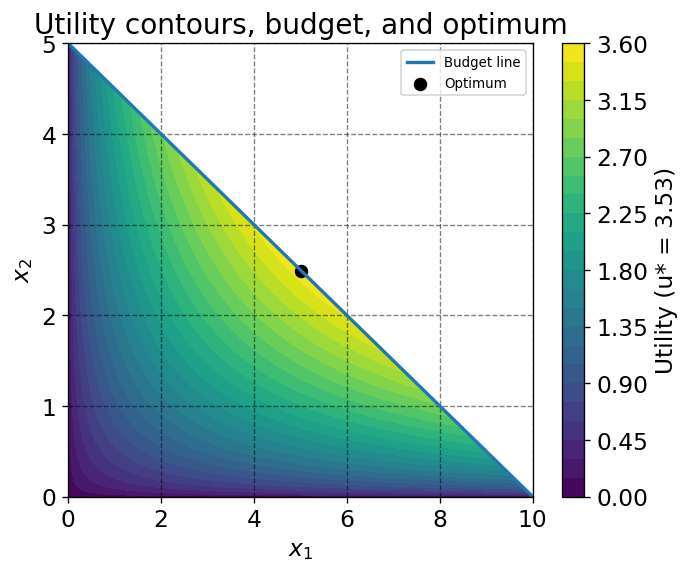

In [6]:
# Mask infeasible grid points so they don't show
infeasible = (p1 * x1_values + p2 * x2_values) > I
u_plot = np.where(infeasible, np.nan, u_values)

# Contour plot
fig, ax = plt.subplots(figsize=(6,5), dpi=120)
cs = ax.contourf(x1_values, x2_values, u_plot, levels=30)

# Colorbar with max utility in the label
cbar = fig.colorbar(cs, ax=ax)
cbar.set_label(f'Utility (u* = {u_best:.2f})')

# Budget line
x1_line = np.linspace(0, I/p1, 200)
x2_line = (I - p1*x1_line) / p2
x2_line = np.maximum(x2_line, 0)
ax.plot(x1_line, x2_line, lw=2, label='Budget line')

# Optimum
ax.scatter(x1_best, x2_best, s=50, c='k', label='Optimum')

# Labels, limits, legend
ax.set_xlim(0, I/p1)
ax.set_ylim(0, I/p2)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Utility contours, budget, and optimum')
ax.legend(fontsize=8)  # smaller legend
ax.grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Task**: Can you find a better solution with higher utility and lower left-over income, $I-p_1 x_1-p_2 x_2$?

In [7]:
# write your code here
# sol = find_best_choice()

<a id="toc2_"></a>
## 3. <a id='toc3_'></a>[Algorithm 2: Optimization using Monotonicity](#toc0_)
[Back to TOC](#top)

Remember that the indifference curve through the point $(y_1,y_2)$ is given by the set of $x_1,x_2$ points
$$
\big\{(x_1,x_2) \in \mathbb{R}^2_+ \,|\, u(x_1,x_2) = u(y_1,y_2)\big\}
$$

To find the indifference curve: 
* fix a grid for $x_2$
* then find the corresponding $x_1$ which solves $u(x_1,x_2) = u(y_1,y_2)$ for each value of $x_2$.

**Simple 1D search on the budget line.**  
Choose an evenly spaced grid for $x_1$ from $0$ to $\tfrac{I}{p_1}$; spend the remainder on $x_2$ and pick the best utility.

Define the grid:
$$
\begin{aligned}
X_1 &= \left\{0,\frac{1}{N-1}\frac{I}{p_1},\frac{2}{N-1}\frac{I}{p_1},\dots,\frac{I}{p_1}\right\} \\
&= \left\{ \frac{k}{N-1}\,\frac{I}{p_1} \;\middle|\; k=0,1,\dots,N-1 \right\}.
\end{aligned}
$$

Implied spending on good 2 (via the budget constraint):
$$
x_2 \;=\; \frac{I - p_1 x_1}{p_2}.
$$

Discrete 1D maximization:
$$
\max_{x_1 \in X_1}\; u(x_1,x_2)
\quad\text{with}\quad
u(x_1,x_2)=x_1^{\alpha}x_2^{1-\alpha},\qquad
x_2=\frac{I-p_1 x_1}{p_2}.
$$
_As $N$ grows, this approximates the continuous optimum._

Function doing just this is `find_best_choice_monotone` in `grid_solve.py`

In [8]:
# a. Calling the algo using monotonicity
# sol_monotone = find_best_choice_monotone(alpha=0.5,I=10,p1=1,p2=2,N=500)
sol_monotone = find_best_choice_monotone(u_func,alpha,I,p1,p2,N=100)

# b. unpack solution
x1_best = sol_monotone.x1_best
x2_best = sol_monotone.x2_best
u_best  = sol_monotone.u_best
x1_values = sol_monotone.x1_values
x2_values = sol_monotone.x2_values
u_values  = sol_monotone.u_values


x1 = 5.0505
x2 = 2.4747
u  = 3.5354
I-p1*x1-p2*x2 = 0.00000000
x1*p1/I = 0.5051


**Discussion**: _What do you notice compared to the first approach? Benefits and Disadvantages?_

In [9]:
# a. create the figure
fig = plt.figure(figsize=(10,4))# figsize is in inches...

# b. left plot
ax_left = fig.add_subplot(1,2,1)

ax_left.plot(x1_values,u_values)
ax_left.scatter(x1_best,u_best) # Add the solution as a dot

ax_left.set_title('value of choice, $u(x_1,x_2)$')
ax_left.set_xlabel('$x_1$')
ax_left.set_ylabel('$u(x_1,(I-p_1 x_1)/p_2)$')


# c. right plot
ax_right = fig.add_subplot(1,2,2)

ax_right.plot(x1_values,x2_values)
ax_right.scatter(x1_best,x2_best)

ax_right.set_title('implied $x_2$ as function of $x_1$')
ax_right.set_xlabel('$x_1$')
ax_right.set_ylabel('$x_2$')

plt.close(fig) # (Suppress print to fit slides) 


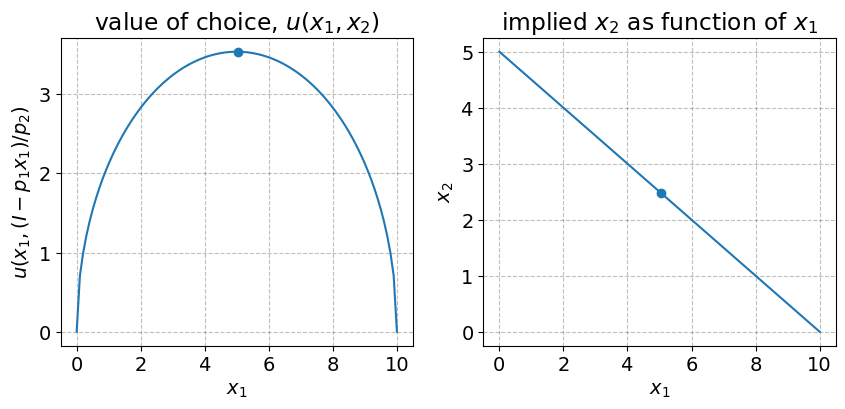

In [10]:
#Show figures of solution
fig

<a id="toc3_"></a>
## 4. <a id='toc4_'></a>[Root-Finding and Calling a Solver](#toc0_)
[Back to TOC](#top)

- **scipy-optimize**: [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html)

In [11]:
# Now we use the library scipy to do the heavy lifting
from scipy import optimize

**Case 1**: Scalar solver using monotonicity.  
Note that we are calling a **minimizer**. Take **negative** of utility.  
Recall that we if we spend everything on good one, we get $x_1 = I/p_1$. 

In [12]:
# a. objective function (to minimize)
def value_of_choice(x1,alpha,I,p1,p2):
    x2 = (I-p1*x1)/p2
    return -u_func(x1,x2,alpha)

# b. call solver
sol_case1 = optimize.minimize_scalar(
    value_of_choice,
    method='bounded',
    bounds=(0,I/p1),
    args=(alpha,I,p1,p2)) # Notice the use of a tuple here

# c. unpack solution
x1 = sol_case1.x
x2 = (I-p1*x1)/p2
u = u_func(x1,x2,alpha)

case1 = SimpleNamespace()
case1.x1=x1
case1.x2=x2     
case1.u=u     

print_solution(x1,x2,u,I,p1,p2)

x1 = 5.0000
x2 = 2.5000
u  = 3.5355
I-p1*x1-p2*x2 = 0.00000000
x1*p1/I = 0.5000


**Case 2**: **Multi-dimensional constrained** solver, the *SLSQP*.
Constrained Optimization with `scipy.optimize.minimize`

We solve the consumer’s problem directly as a constrained program:
$$
\begin{aligned}
\max_{x_1,x_2} \quad & u(x_1,x_2) \\
\text{s.t.}\quad &
\begin{cases}
p_1x_1 + p_2x_2 \le I,\\[2pt]
0 \le x_1 \le \tfrac{I}{p_1},\\[2pt]
0 \le x_2 \le \tfrac{I}{p_2}.
\end{cases}
\end{aligned}
$$

To use a minimization routine, rewrite it as:
$$
\begin{aligned}
\min_{x_1,x_2} \quad & -u(x_1,x_2) \\
\text{s.t.}\quad &
\underbrace{I - p_1x_1 - p_2x_2}_{g(x)} \;\ge\; 0 \quad (\text{inequality constraint}),\\[4pt]
& \ell \;\le\; x \;\le\; u \qquad (\text{box bounds}),
\end{aligned}
$$
with $x=(x_1,x_2)^\top$, lower bound $\ell=(0,0)^\top$, and upper bound $u=(I/p_1,\; I/p_2)^\top$.

This formulation is general (works even when FOCs are messy or do not yield a closed form) and matches what `SLSQP` solves: minimize $-u(x)$ subject to $g(x)\ge 0$ and box bounds.


In [13]:
from functools import partial

# a) Objective function: we want to MAXIMIZE utility u(x1,x2).
# scipy.minimize can only MINIMIZE, so we minimize the NEGATIVE utility.
# Note: 'x' is a length-2 array [x1, x2]; u_func expects scalar inputs.

# a) Objective (minimize -u)
def value_of_choice(x, alpha, I, p1, p2):
    return -u_func(x[0], x[1], alpha=alpha)

# Bind parameters so we can call obj(x) without extra args
obj = partial(value_of_choice, alpha=alpha, I=I, p1=p1, p2=p2)

# b) Feasibility and bounds.
#    Constraint (type='ineq') requires: fun(x) >= 0  ⇔  I - p1*x1 - p2*x2 >= 0
#    This enforces expenditures ≤ income (budget not exceeded).
constraints = ({'type': 'ineq', 'fun': lambda x: I - p1*x[0] - p2*x[1]})
#    Bounds enforce non-negativity and trivial per-good maxima from the budget:
#    0 ≤ x1 ≤ I/p1,  0 ≤ x2 ≤ I/p2
bounds = ((0, I/p1), (0, I/p2))

# c) Initial guess  -- we will also discuss the importance of starting values
init_guess = np.array([0.1*I/p1, 0.9*I/p2])

# Another guess: spend half of income on each good (in quantity terms).
# init_guess = np.array([I/(2*p1), I/(2*p2)], dtype=float)

# ---- progress storage (globals kept, but now consistent) ----
x1s, x2s, fs = [], [], []


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.5355339059327378
            Iterations: 7
            Function evaluations: 21
            Gradient evaluations: 7
x1 = 5.0000
x2 = 2.5000
u  = 3.5355
I-p1*x1-p2*x2 = -0.00000000
x1*p1/I = 0.5000


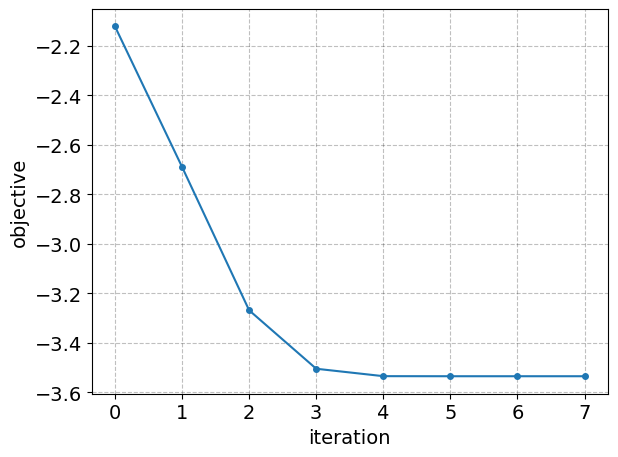

In [14]:
import optimize_funcs as of
from scipy import optimize
from types import SimpleNamespace

# 1) init the collector with your objective and initial guess
of.init_collector(obj, init_guess)

# 2) run SLSQP with the module's callback
sol_case2 = optimize.minimize(
    obj, init_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    callback=of.collect,
    options={'ftol': 1e-12, 'disp': True}
)

# 3) unpack solution as before
x1, x2 = sol_case2.x
u = u_func(x1, x2, alpha)
print_solution(x1, x2, u, I, p1, p2)
case2 = SimpleNamespace(x1=x1, x2=x2, u=u)

# 4) plot the convergence (objective or utility)
of.convergence_steps(plot_utility=False)   # objective
# of.convergence_steps(plot_utility=True)  # utility = -objective


Now, we can use the saved information to plot the number of iterations needed for convergence.

_Task: Change the starting value and see how the number of iterations change!_

**Note:** Good starting values can make nonlinear optimizers converge faster and to better solutions; poor initials risk slowdowns, infeasibility, or getting trapped in bad local minima.

**Case 3**: Multi-dimensional unconstrained solver with constrains implemented via penalties.

In [15]:
# a. objective function (to minimize)
def value_of_choice(x,alpha,I,p1,p2):
    
    # i. unpack
    x1 = x[0]
    x2 = x[1]
    
    # ii. penalty
    penalty = 0
    E = p1*x1+p2*x2 # total expenses
    if E > I: # expenses > income -> not allowed
        fac = I/E # fac < 1 if too high expenses
        penalty += 1000*(E-I) # calculate penalty        
        x1 *= fac # force E = I
        x2 *= fac # force E = I
        
    return -u_func(x1,x2,alpha) + penalty

In [16]:
# b. call solver
initial_guess = [I/p1/2,I/p2/2]
sol_case3 = optimize.minimize(
    value_of_choice,initial_guess,method='Nelder-Mead',
    args=(alpha,I,p1,p2))

# c. unpack solution
x1 = sol_case3.x[0]
x2 = sol_case3.x[1]
u = u_func(x1,x2,alpha)
print_solution(x1,x2,u,I,p1,p2)

case3 = SimpleNamespace()
case3.x1=x1
case3.x2=x2     
case3.u=u   

x1 = 5.0000
x2 = 2.5000
u  = 3.5355
I-p1*x1-p2*x2 = 0.00000000
x1*p1/I = 0.5000


<a id="toc4_"></a>
## 5. <a id='toc5_'></a>[Comparing Methods](#toc0_)
[Back to TOC](#top)



In [19]:
print(f"Grid search           : x1={sol_grid_simple.x1_best:.4f}, x2={sol_grid_simple.x2_best:.4f}, u={sol_grid_simple.u_best:.4f}")
print(f"Use Monotonicity      : x1={sol_monotone.x1_best:.4f}, x2={sol_monotone.x2_best:.4f}, u={sol_monotone.u_best:.4f}")
print(f"Minimization solver   : x1={case1.x1:.4f}, x2={case1.x2:.4f}, u={case1.u:.4f}")
print(f"Constrained solver    : x1={case2.x1:.4f}, x2={case2.x2:.4f}, u={case2.u:.4f}")
print(f"Unconstrained solver  : x1={case3.x1:.4f}, x2={case3.x2:.4f}, u={case3.u:.4f}")

Grid search           : x1=5.0100, x2=2.4937, u=3.5346
Use Monotonicity      : x1=5.0505, x2=2.4747, u=3.5354
Minimization solver   : x1=5.0000, x2=2.5000, u=3.5355
Constrained solver    : x1=5.0000, x2=2.5000, u=3.5355
Unconstrained solver  : x1=5.0000, x2=2.5000, u=3.5355


<a id="toc7_"></a>
## 6. <a id='toc6_'></a>[Summary](#toc0_)
[Back to TOC](#top)

- **Grid search** builds intuition by exploring the whole budget set.  
- **Root-finding** solves the **FOC = 0** condition and connects directly to marginal analysis.  
- **Constrained optimization** is a **general workhorse** for problems without clean FOCs or with complex constraints.  

In real research, start with a **robust method** (grid/bracketing), then switch to a **faster method** once you understand the landscape.
